<a href="https://colab.research.google.com/github/amsewr/planeclassification/blob/main/notebooks/train_classification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load data & imports

In [1]:
!curl -O https://www.robots.ox.ac.uk/~vgg/data/fgvc-aircraft/archives/fgvc-aircraft-2013b.tar.gz
!tar zxf fgvc-aircraft-2013b.tar.gz
!mv fgvc-aircraft-2013b dataset 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2625M  100 2625M    0     0  29.2M      0  0:01:29  0:01:29 --:--:-- 30.1M


In [2]:
%%writefile requirements.txt

pathlib==1.0.1
matplotlib==3.5.0
numpy==1.21.5
pandas==1.3.5
tensorflow==2.8.0
keras==2.8.0

Writing requirements.txt


In [ ]:
!pip install -r requirements.txt

In [1]:
import pathlib 

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import yaml

from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

from sklearn.model_selection import train_test_split
from PIL import Image
from yaml.loader import SafeLoader

# Constantes

In [30]:
%%writefile launch.yaml

---
DATA_DIR: dataset/data
MODEL_DIR: model/planes
TARGET_NAME : family



IMAGE_WIDTH: 128
IMAGE_HEIGHT: 128
IMAGE_DEPTH: 3

Overwriting launch.yaml


In [31]:
with open('launch.yaml') as f:
  data = yaml.load(f, Loader=SafeLoader)
  print(data)

{'DATA_DIR': 'dataset/data', 'MODEL_DIR': 'model/planes', 'TARGET_NAME': 'family', 'IMAGE_WIDTH': 128, 'IMAGE_HEIGHT': 128, 'IMAGE_DEPTH': 3}


In [32]:
DATA_DIR = pathlib.Path(data['DATA_DIR'])
MODEL_DIR = pathlib.Path(data['MODEL_DIR'])
TARGET_NAME = data['TARGET_NAME']
IMAGE_WIDTH = data['IMAGE_WIDTH']
IMAGE_HEIGHT = data['IMAGE_HEIGHT']
IMAGE_DEPTH = data['IMAGE_DEPTH']

# Functions

In [5]:
def build_image_database(path, target) :
  """Build a pandas dataframe with target class and access path to images.

  Parameters
  ----------
  path (Path) : path pattern to read csv file containing images information. 
  target (str) : name of the target column.

  Returns 
  -------
  A pandas dataframe, including target class and path to image.
  """

  _df =pd.read_csv(path, sep='\t'
                , names=['all']
                , dtype ={'all':str} # id are string not int
                )

  #split donne une chaine de caractères
  _df['image_id'] = _df['all'].apply(lambda x: x.split(' ')[0])

  #'<car>'.join(liste) concatène les éléments de la liste avec le séparateur '<car>'
  _df[target] = _df['all'].apply(lambda x: ' '.join(x.split(' ')[1:]))

  # La colonne path contient le chemin d'accès à l'image
  _df['path'] = _df['image_id'].apply(lambda x: pathlib.Path('dataset/data/images') / (x +'.jpg'))

  return _df.drop(columns=['all'])

In [37]:
manufacturer_df = build_image_database(DATA_DIR / 'images_{}_train.txt'.format(TARGET_NAME), TARGET_NAME)

In [7]:
# La fonction :
# - prend un df (argument) 
# - prend une ligne (row : argument, l'indice de la ligne)
# - prend une colonne (target : argument)
# - elle affiche la classe (valeur de target) et l'image associée, pour la ligne en argument

def show_image(df, row, target) : 
  """Show an image from an image database, with the associated class

  Parameters
  -----------
  df(pd.DataFrame) : images definition dataframe
  row (int) :  row index in df of image to be displayed
  target (str) : name of the target column

  Returns
  ---------
  None
  """
  assert target in df.columns, "Missing target column in dataframe"
  assert 'path' in df.columns, "Missing image path in dataframe"
  print(df.iloc[row,][target])
  plt.imshow(plt.imread(df.iloc[row,]['path']))

  return

DH-82


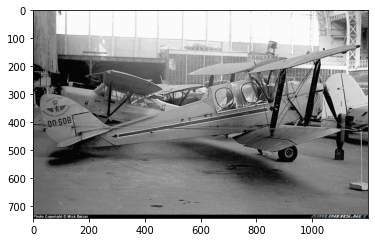

In [38]:
show_image(manufacturer_df, 1930, TARGET_NAME)

# Verify data

In [40]:
manufacturer_df[TARGET_NAME].value_counts(dropna=False)

Boeing 737         267
Boeing 747         133
A320               133
A340               133
Boeing 767         100
                  ... 
Boeing 717          33
F/A-18              33
Falcon 2000         33
Beechcraft 1900     33
DHC-6               33
Name: family, Length: 70, dtype: int64

In [41]:
assert manufacturer_df['image_id'].isna().sum() == 0, "Missing values in image_id"
assert manufacturer_df[TARGET_NAME].isna().sum() == 0, "Missing values in manufcaturer"

# Tenserflow

In [ ]:
manufacturer_df.shape

(3334, 3)

In [39]:
manufacturer_df.head()

,image_id,family,path
0,1025794,Boeing 707,dataset/data/images/1025794.jpg
1,1340192,Boeing 707,dataset/data/images/1340192.jpg
2,0056978,Boeing 707,dataset/data/images/0056978.jpg
3,0698580,Boeing 707,dataset/data/images/0698580.jpg
4,0450014,Boeing 707,dataset/data/images/0450014.jpg


Boeing 707


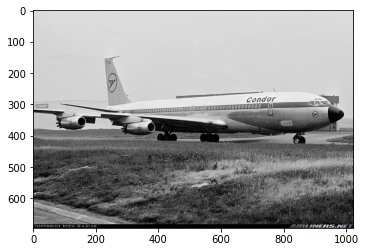

In [42]:
show_image(manufacturer_df, 0, TARGET_NAME)

In [43]:
manufacturer_df['shape'] = manufacturer_df['path'].apply(lambda p: plt.imread(p).shape)

In [ ]:
# Distribution du nombre de colonnes
manufacturer_df['shape'].apply(lambda x: x[1]).value_counts()

1024    1399
1200     618
1000     492
1600     145
1050     105
        ... 
1375       1
993        1
941        1
1013       1
995        1
Name: shape, Length: 73, dtype: int64

In [11]:
def load_resize_image(path, height, width):
  """Load an image and resize it to the target size.

  Parameters
  ----------
  path (Path): access path to image file
  height (int): resize image to this height
  width (int): resize image to this width
  
  Returns
  -------
  np.array containing resized image
  """
  return np.array(Image.open(path).resize((width, height)))

In [44]:
manufacturer_df['resized_image'] = manufacturer_df.apply(lambda r: load_resize_image(r['path'], IMAGE_HEIGHT, IMAGE_WIDTH), axis=1)

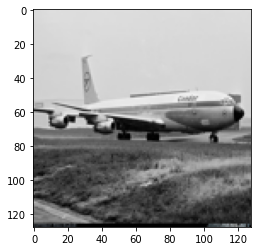

In [ ]:
plt.imshow(manufacturer_df.iloc[0,]['resized_image'])

In [ ]:
# Calcul du nombre de classes pour dimensionner la couche de sortie
nb_classes = manufacturer_df[TARGET_NAME].nunique()
nb_classes

30

In [13]:
def build_classification_model(df, target, images):
  """Build a TF model using information from target and images columns in dataframe. 

  Parameters
  ----------
  df (pd.DataFrame) : dataframe with target and images columns
  target (str) : column name for target variable
  images (str) : column name for images

  Returns
  -------
  TF model built a compiled
  """
  nb_classes = df[target].nunique() # compute number of classes for output layer
  size = df[images].iloc[0].shape # compute images size for input layer

  #Building the model
  model = Sequential()
  model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape= size))
  model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(rate=0.25))
  model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
  model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(rate=0.25))
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(rate=0.5))
  model.add(Dense(nb_classes, activation='softmax'))

  #Compilation of the model
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

# Build train & test set

In [14]:
def build_x_and_y(df : pd.DataFrame, target : str, images : str):
  """Build x tensor and y tensor for model fitting. 

  Parameters
  -----------
  df (pd.DataFrame) : dataframe containing images and target 
  target (str) : name of target column
  images (str) : name of images column

  Returns
  ---------
  x (np.array) : tensor for x values 
  y (np.array) : tensor for y valuess
  """

  x = np.array(df[images].to_list())
  y = tf.keras.utils.to_categorical(df[target].astype('category').cat.codes)
  return x, y


In [47]:
# Load train & test dataset
train_df = build_image_database(DATA_DIR / 'images_{}_train.txt'.format(TARGET_NAME), TARGET_NAME)
test_df = build_image_database(DATA_DIR / 'images_{}_test.txt'.format(TARGET_NAME), TARGET_NAME)

# Load & resize images
train_df['resized_images'] = train_df.apply(lambda r: load_resize_image(r['path'], IMAGE_HEIGHT, IMAGE_WIDTH), axis=1)
test_df['resized_images'] = test_df.apply(lambda r: load_resize_image(r['path'], IMAGE_HEIGHT, IMAGE_WIDTH), axis=1)

# Build tensors for training & testing
X_train, y_train = build_x_and_y(train_df, TARGET_NAME, 'resized_images')
X_test, y_test = build_x_and_y(test_df, TARGET_NAME, 'resized_images')

# Build TF classification model
model = build_classification_model(train_df, TARGET_NAME, 'resized_images')

In [ ]:
# A faire une fois pour récupérer les informations sur la TPU
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [48]:
with tpu_strategy.scope():
  model = build_classification_model(train_df, TARGET_NAME, 'resized_images')

In [18]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
import datetime

!rm -rf ./logs
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [49]:
%%time
epochs = 30
history = model.fit(X_train, y_train, batch_size=96, epochs=epochs,
                    validation_data=(X_test, y_test))

Epoch 1/30
35/35 [==============================] - 39s 796ms/step - loss: 24.3945 - accuracy: 0.0531 - val_loss: 4.1956 - val_accuracy: 0.0801
Epoch 2/30
35/35 [==============================] - 3s 79ms/step - loss: 4.1227 - accuracy: 0.0774 - val_loss: 4.0564 - val_accuracy: 0.0774
Epoch 3/30
35/35 [==============================] - 3s 77ms/step - loss: 3.9966 - accuracy: 0.0801 - val_loss: 3.9605 - val_accuracy: 0.0852
Epoch 4/30
35/35 [==============================] - 3s 78ms/step - loss: 3.8236 - accuracy: 0.1008 - val_loss: 3.8085 - val_accuracy: 0.0987
Epoch 5/30
35/35 [==============================] - 3s 80ms/step - loss: 3.5926 - accuracy: 0.1290 - val_loss: 3.8168 - val_accuracy: 0.1269
Epoch 6/30
35/35 [==============================] - 3s 78ms/step - loss: 3.3365 - accuracy: 0.1791 - val_loss: 3.6710 - val_accuracy: 0.1323
Epoch 7/30
35/35 [==============================] - 3s 79ms/step - loss: 3.0263 - accuracy: 0.2385 - val_loss: 3.5769 - val_accuracy: 0.1611
Epoch 8/30

In [87]:
train_df[TARGET_NAME].astype('category').cat.categories

Index(['A300', 'A310', 'A320', 'A330', 'A340', 'A380', 'ATR-42', 'ATR-72',
       'An-12', 'BAE 146', 'BAE-125', 'Beechcraft 1900', 'Boeing 707',
       'Boeing 717', 'Boeing 727', 'Boeing 737', 'Boeing 747', 'Boeing 757',
       'Boeing 767', 'Boeing 777', 'C-130', 'C-47', 'CRJ-200', 'CRJ-700',
       'Cessna 172', 'Cessna 208', 'Cessna Citation', 'Challenger 600',
       'DC-10', 'DC-3', 'DC-6', 'DC-8', 'DC-9', 'DH-82', 'DHC-1', 'DHC-6',
       'DR-400', 'Dash 8', 'Dornier 328', 'EMB-120', 'Embraer E-Jet',
       'Embraer ERJ 145', 'Embraer Legacy 600', 'Eurofighter Typhoon', 'F-16',
       'F/A-18', 'Falcon 2000', 'Falcon 900', 'Fokker 100', 'Fokker 50',
       'Fokker 70', 'Global Express', 'Gulfstream', 'Hawk T1', 'Il-76',
       'King Air', 'L-1011', 'MD-11', 'MD-80', 'MD-90', 'Metroliner', 'PA-28',
       'SR-20', 'Saab 2000', 'Saab 340', 'Spitfire', 'Tornado', 'Tu-134',
       'Tu-154', 'Yak-42'],
      dtype='object')

In [85]:
with open('cat.yaml') as outfile:
    yaml.dump(CAT, default_flow_style=False)

In [ ]:
with open('cat.yaml') as f:
  data = yaml.load(f, Loader=SafeLoader)
  print(data)

In [90]:
%%writefile cat.yaml

---
categories_family : ['A300', 'A310', 'A320', 'A330', 'A340', 'A380', 'ATR-42', 'ATR-72',
       'An-12', 'BAE 146', 'BAE-125', 'Beechcraft 1900', 'Boeing 707',
       'Boeing 717', 'Boeing 727', 'Boeing 737', 'Boeing 747', 'Boeing 757',
       'Boeing 767', 'Boeing 777', 'C-130', 'C-47', 'CRJ-200', 'CRJ-700',
       'Cessna 172', 'Cessna 208', 'Cessna Citation', 'Challenger 600',
       'DC-10', 'DC-3', 'DC-6', 'DC-8', 'DC-9', 'DH-82', 'DHC-1', 'DHC-6',
       'DR-400', 'Dash 8', 'Dornier 328', 'EMB-120', 'Embraer E-Jet',
       'Embraer ERJ 145', 'Embraer Legacy 600', 'Eurofighter Typhoon', 'F-16',
       'F/A-18', 'Falcon 2000', 'Falcon 900', 'Fokker 100', 'Fokker 50',
       'Fokker 70', 'Global Express', 'Gulfstream', 'Hawk T1', 'Il-76',
       'King Air', 'L-1011', 'MD-11', 'MD-80', 'MD-90', 'Metroliner', 'PA-28',
       'SR-20', 'Saab 2000', 'Saab 340', 'Spitfire', 'Tornado', 'Tu-134',
       'Tu-154', 'Yak-42']

categories_manufacturer : ['ATR', 'Airbus', 'Antonov', 'Beechcraft', 'Boeing',
       'Bombardier Aerospace', 'British Aerospace', 'Canadair', 'Cessna',
       'Cirrus Aircraft', 'Dassault Aviation', 'Dornier',
       'Douglas Aircraft Company', 'Embraer', 'Eurofighter', 'Fairchild',
       'Fokker', 'Gulfstream Aerospace', 'Ilyushin', 'Lockheed Corporation',
       'Lockheed Martin', 'McDonnell Douglas', 'Panavia', 'Piper', 'Robin',
       'Saab', 'Supermarine', 'Tupolev', 'Yakovlev', 'de Havilland']

Overwriting cat.yaml


In [25]:
def classify_images(images, model,classes_names=None):
  """Classify images through a TF model.

  Parameters
  ----------
  images (np.array): set of images to classify
  model (tf.keras.Model): TF/Keras model
  classes_names : dictionary with names of classes

  Returns
  --------
  predicted classes
  """

  results = model.predict(images) # predict for images
  classes = np.argmax(results, axis=1) # np.argmax is computed row by row
  if classes_names is not None:
    classes = np.array(classes_names[classes])
  return classes

<AxesSubplot:xlabel='col_0', ylabel='row_0'>

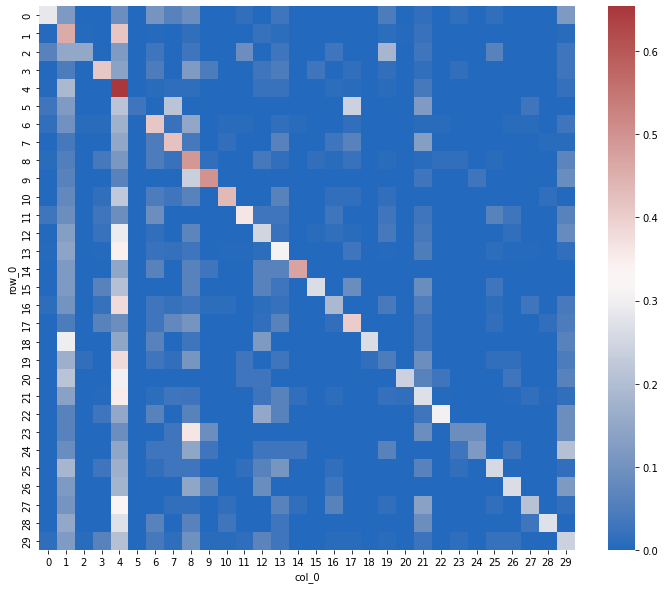

In [27]:
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(pd.crosstab(np.argmax(y_test, axis=1), classify_images(X_test, model), normalize='index'), cmap='vlag',ax=ax)

<AxesSubplot:xlabel='col_0', ylabel='family'>

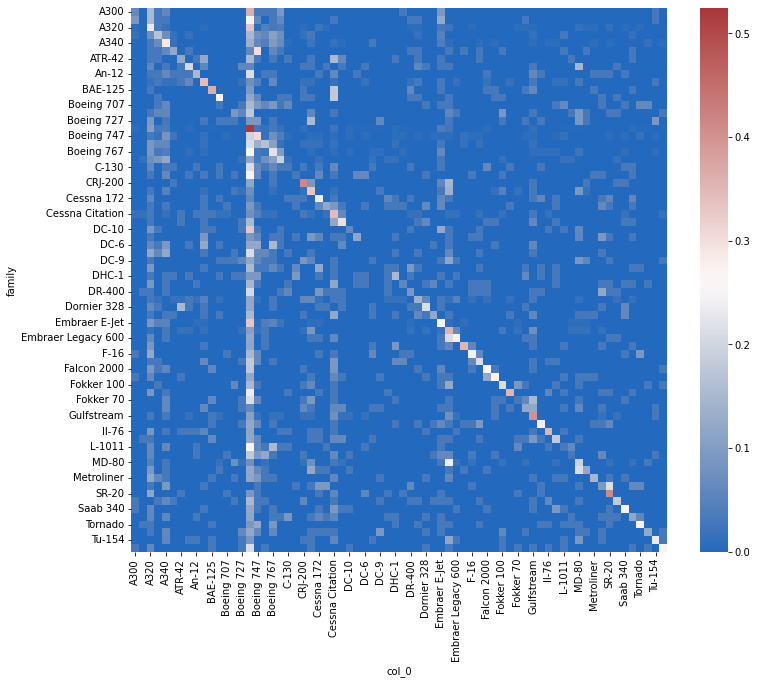

In [50]:
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(pd.crosstab(test_df[TARGET_NAME], classify_images(X_test, model,test_df[TARGET_NAME].astype('category').cat.categories), 
                        normalize='index'), cmap='vlag',ax=ax)

In [51]:
import datetime

def save_model(model, basename):
  """Save tf/Keras model.

  Model file is named model + timestamp.

  Parameters
  ----------
  model (tf/Keras model): model to be saved
  basename: location to save model file
  """
  model.save('{}_{}.h5'.format(basename, TARGET_NAME))
  return

In [52]:
save_model(model,MODEL_DIR)